# **Measuring Bias in multiclass classification**


This tutorial will explain how to measure bias in a multiclass classification task using the holisticai library. We will introduce here some of the functions that can help study algorithmic bias.

The sections are organised as follows :
1. Load the data : we load the student dataset as a pandas DataFrame
2. Data Exploration : some preliminary analysis of the data
3. Train a Model : we train a model (sklearn)
4. Measure Bias : we compute a few bias metrics, and comment on their meaning

## **Load the data**

In [1]:
# Base imports
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd

The student dataset can be easily

In [2]:
from holisticai.datasets import load_student

In [3]:
# load data
df = load_student()['frame']

# Make data multiclass by slicing into 4 buckets
y = df['G3'].to_numpy()
buckets = np.array([8, 11, 14])
y_cat = (y.reshape(-1, 1) > buckets.reshape(1, -1)).sum(axis=1)
df['target'] = y_cat

# map dictionary
grade_dict = {0:'very-low', 1:'low', 2:'high',3:'very-high'}
df['target'] = df['target'].map(grade_dict)

# drop the other grade columns
df = df.drop(columns=['G1','G2','G3'])

df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,target
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,...,no,no,4.0,3.0,4.0,1.0,1.0,3.0,6.0,very-low
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,...,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,4.0,very-low
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,...,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,10.0,low
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,...,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,2.0,very-high
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,...,no,no,4.0,3.0,2.0,1.0,2.0,5.0,4.0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20.0,U,LE3,A,2.0,2.0,services,services,...,no,no,5.0,5.0,4.0,4.0,5.0,4.0,11.0,low
391,MS,M,17.0,U,LE3,T,3.0,1.0,services,services,...,yes,no,2.0,4.0,5.0,3.0,4.0,2.0,3.0,very-high
392,MS,M,21.0,R,GT3,T,1.0,1.0,other,other,...,no,no,5.0,5.0,3.0,3.0,3.0,3.0,3.0,very-low
393,MS,M,18.0,R,LE3,T,3.0,2.0,services,other,...,yes,no,4.0,4.0,1.0,3.0,4.0,5.0,0.0,low


## **Data Exploration**

In [4]:
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.plots import frequency_plot

<AxesSubplot:>

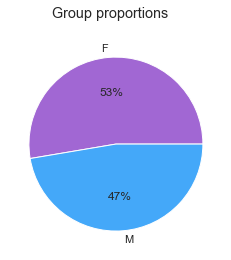

In [5]:
group_pie_plot(df['sex'])

<AxesSubplot:>

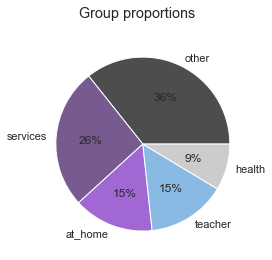

In [6]:
group_pie_plot(df['Mjob'])

<AxesSubplot:xlabel='target', ylabel='Probability'>

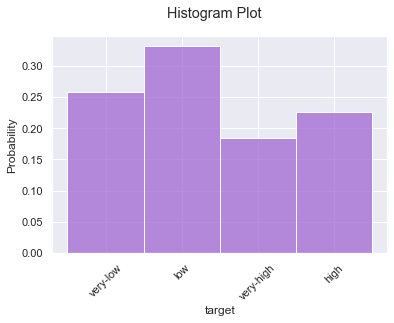

In [7]:
histogram_plot(df['target'])

<AxesSubplot:xlabel='Class', ylabel='Group'>

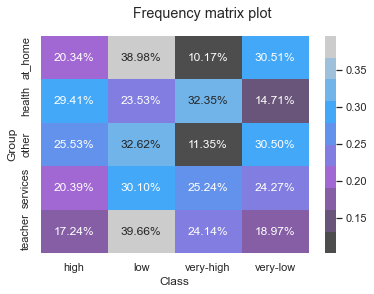

In [8]:
frequency_matrix_plot(df['Mjob'], df['target'], normalize='group')

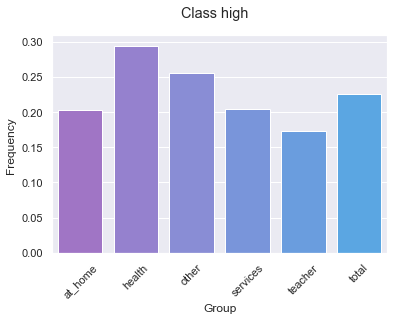

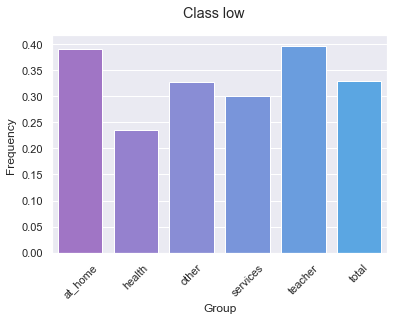

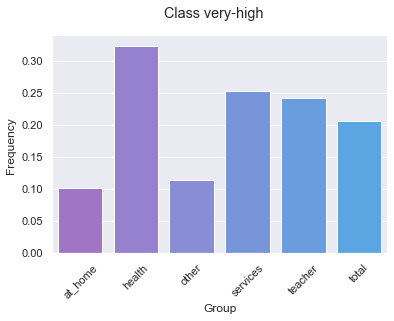

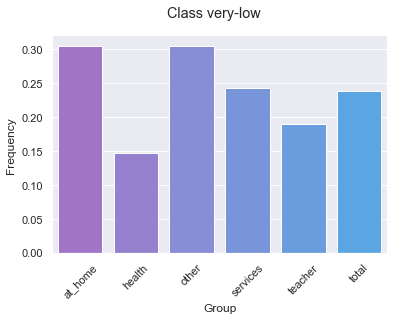

In [9]:
frequency_plot(df['Mjob'], df['target'])

## **Train a model**


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [11]:
# preprocess categorical columns
def preprocess_data(data, protected_attributes, label_attributes):
    categoricals = []
    for col in data.columns:
        if col not in protected_attributes and col not in label_attributes and data[col].dtype == object:
            categoricals.append(col)

    cat_encoder = OneHotEncoder()  
    enc = cat_encoder.fit_transform(data[categoricals])
    enc = pd.DataFrame(enc.toarray())
    df = pd.concat([data,enc],axis=1).drop(columns=categoricals) # add encoded columns
    df = df.rename(str, axis='columns')
    return df

In [12]:
# we don't want to encode protected attributes
protected_attributes = ['sex', 'address', 'Mjob', 'Fjob']
label_attributes = ['target']

# Load, preprocess and split for training
preproc_data = preprocess_data(df, protected_attributes, label_attributes)
train, test = train_test_split(preproc_data, test_size=0.4, random_state=42)

# display
preproc_data

,sex,age,address,Medu,Fedu,Mjob,Fjob,traveltime,studytime,failures,...,19,20,21,22,23,24,25,26,27,28
0,F,18.0,U,4.0,4.0,at_home,teacher,2.0,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,F,17.0,U,1.0,1.0,at_home,other,1.0,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,F,15.0,U,1.0,1.0,at_home,other,1.0,2.0,3.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,F,15.0,U,4.0,2.0,health,services,1.0,3.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,F,16.0,U,3.0,3.0,other,other,1.0,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,M,20.0,U,2.0,2.0,services,services,1.0,2.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
391,M,17.0,U,3.0,1.0,services,services,2.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
392,M,21.0,R,1.0,1.0,other,other,1.0,1.0,3.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
393,M,18.0,R,3.0,2.0,services,other,3.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [13]:
# set up data for training
X_train = train.drop(columns=label_attributes)
X_test = test.drop(columns=label_attributes)
y_train = train['target']
y_test = test['target']

# Train a simple Random Forest Classifier
model = RandomForestClassifier(random_state=111)
model.fit(X_train.drop(columns=protected_attributes), y_train)

# Predict values
y_pred = model.predict(X_test.drop(columns=protected_attributes))

In [14]:
from holisticai.bias.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [15]:
confusion_matrix(y_pred, y_test, classes=['very-low','low','high','very-high'])

,very-low,low,high,very-high
very-low,18.0,4.0,1.0,2.0
low,19.0,32.0,22.0,10.0
high,7.0,8.0,8.0,11.0
very-high,3.0,3.0,2.0,8.0


In [16]:
# evaluate
print (accuracy_score(y_test, y_pred))
print (precision_score(y_test, y_pred, average=None, labels=['very-low','low','high','very-high']))
print (recall_score(y_test, y_pred, average=None, labels=['very-low','low','high','very-high']))

0.4177215189873418
[0.72       0.38554217 0.23529412 0.5       ]
[0.38297872 0.68085106 0.24242424 0.25806452]


## **Measure bias**

In [17]:
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.plots import frequency_plot

In [18]:
# set up vectors
p_attr = test['Mjob']                                               # protected attribute
y_pred = model.predict(X_test.drop(columns=protected_attributes))   # multiclass prediction vector
y_true = y_test                                                     # multiclass label vector

<AxesSubplot:xlabel='Class', ylabel='Group'>

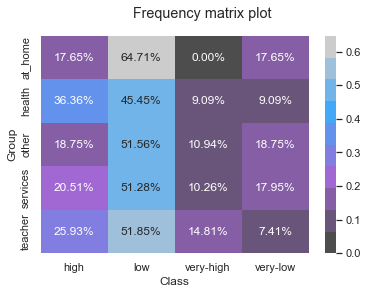

In [19]:
frequency_matrix_plot(p_attr, y_pred, normalize='group')

Using the above plot, we observe unfairness by looking at differences over columns. For instance we look at the 'high' column, and observe how the 'health' group has a much higher probability of being within it.

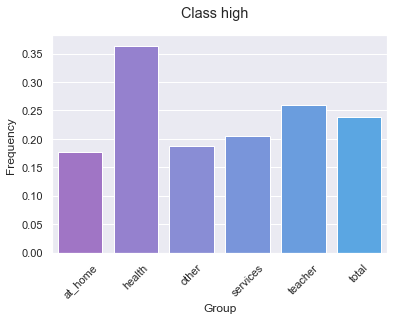

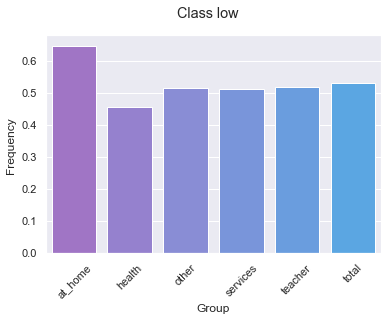

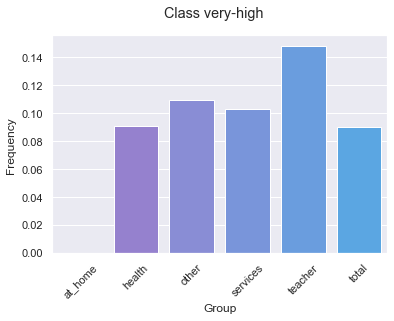

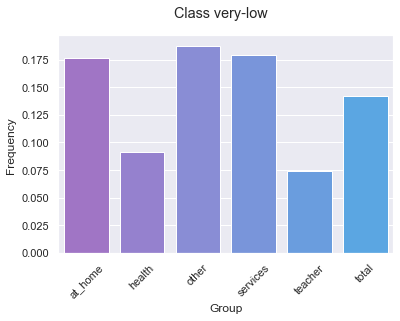

In [20]:
frequency_plot(p_attr, y_pred)

This is the same data as the previous plot, but displayed in a different way.

Let's compute a few bias metrics. We have generalised versions of '1d' bias metrics. For instance multiclass statistical parity.

In [21]:
from holisticai.bias.metrics import multiclass_statistical_parity

multiclass_statistical_parity(
    p_attr, y_pred, groups=None, classes=None, aggregation_fun="mean"
)

0.14670076995444642

We now compute statistical parity, generalized for the multiclass case. We aggregate by taking the average multilabel statistical parity over all possible group pairs (`aggregation_fun="mean"`). As in the 1d case, the suggested accepted range is (-0.1, 0.1).

In [22]:
multiclass_statistical_parity(
    p_attr, y_pred, groups=None, classes=None, aggregation_fun="max"
)

0.2780748663101605

Alternatively, we could aggregate by taking the maximum (`aggregation_fun="max"`) over all possible group pairs. As expected, the maximum statistical parity is higher in this case.

We can try another bias metric, for instace multiclass_equality_of_opp is the multidimensional version of the 1d equal opportunity metric.

In [23]:
from holisticai.bias.metrics import multiclass_equality_of_opp

multiclass_equality_of_opp(
    p_attr, y_pred, y_true, groups=None, classes=None, aggregation_fun="mean"
)

0.3420002687529861

In [24]:
multiclass_equality_of_opp(
    p_attr, y_pred, y_true, groups=None, classes=None, aggregation_fun="max"
)

0.46875